In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:6')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.2+cu102  Device: cuda:6


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [5]:
for (X_train, y_train) in train_loader:
    print(X_train.size(),y_train.size())
    print(X_train.type(),y_train.type())
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])
torch.FloatTensor torch.LongTensor


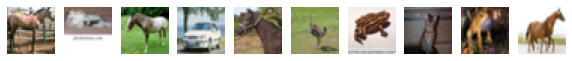

In [9]:
pltsize= 1
plt.figure(figsize=(pltsize*10,pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x 
        

In [20]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [21]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [26]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= (len(test_loader.dataset)/BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [27]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 1.681927
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.481993
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.710006
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.556783
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.442311
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.527188
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.696258
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.722538

[EPOCH: 1], 	Test Loss: 1.5432, 	Test Accuracy: 44.47 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.982634
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.606347
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.370228
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.592456
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.561225
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.501782
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.541946
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.632507

[EPOCH: 2], 	Test Loss: 1.5784, 	Test Accuracy: 43.06 % 

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [34]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [35]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [36]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= (len(test_loader.dataset)/BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [37]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

<ipython-input-33-bcf9cc59713d>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.333787
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.809390
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.040472
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.850176
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.788047
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.379435
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.424644
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.313241

[EPOCH: 1], 	Test Loss: 1.4468, 	Test Accuracy: 47.27 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.240809
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.248372
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.739860
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.507386
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.330555
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.273061
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.226251
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.262805

[EPOCH: 2], 	Test Loss: 1.3830, 	Test Accuracy: 50.22 % 

In [39]:
train_dataset = datasets.CIFAR10(root="../data/CIFAR_10",train=True, download=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_dataset = datasets.CIFAR10(root="../data/CIFAR_10",train=False, transform=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [40]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

<ipython-input-33-bcf9cc59713d>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 1.827037
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 0.889712
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.298382
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.091101
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.262434
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.720957
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.164931
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.750431

[EPOCH: 1], 	Test Loss: 1.0587, 	Test Accuracy: 63.57 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.014719
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.966095
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.142999
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.406000
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.957540
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.885385
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.152896
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.110188

[EPOCH: 2], 	Test Loss: 1.0275, 	Test Accuracy: 64.50 % 